Melvin Woodly's paper, "Decoupling the individual effects of multiple marketing channels with state space models," which casts the Koyck model into a state space framework, served as the impetus for this work.
The study looks at a multiple advertising Koyck model that uses a number of channels and shows how this context can be managed using the state space representation.  It also illustrates how the model can be estimated using the Kalman filter.

The advantages of this representation are numerous and have been extensively discussed in the most recent studies that advocate for its use.  One is the dynamic intercept possibility that is offered by this dynamic representation, in which the coefficient is permitted to follow an unresolvable trajectory.

The Koyck model is not frequently employed in its ARMA representation, and the gemotric decay version is the most prevalent. Additionally, the state space representation of the Koyck model is a niche topic in this particular literature.

Consequently, the objective of this demo is to examine the straightforward version of the ARMA Koyck model for single-channel advertising and demonstrate the potential of the state space representation.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm
from scipy.optimize import minimize

The Data generation process is the same as the one used before for generating a Koyck process.
$$ y_t = \beta_0 + \beta_1 \sum_{j=0}^{\infty}{\lambda^j x_{t-j}}+ \epsilon_t $$

This model can also be written in its ARMA version:
$$ y_t = \beta_0^* + \beta_1 x_t + \lambda y_{t-1} - \lambda \epsilon_{t-1} + \epsilon_t $$

The focus will be on the ARMA version as noted in the author work.

Text(0.5, 1.0, 'Advertising series and the Ad-stock')

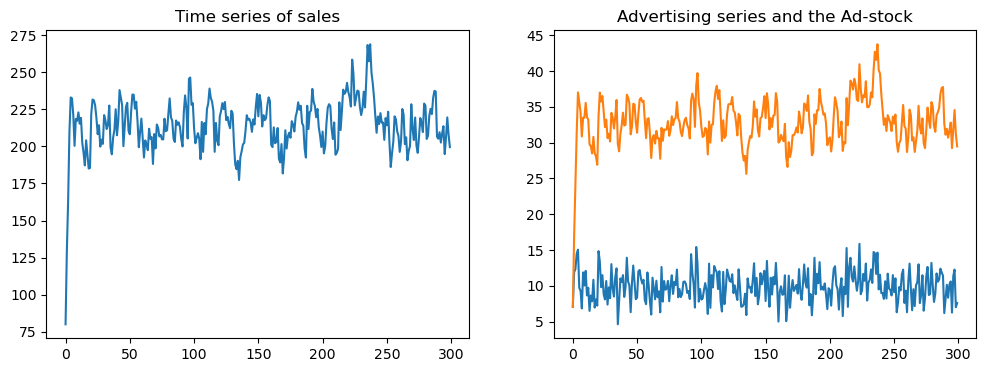

In [34]:
#Data generation process: Ad-stock model 
a0 = 50
a1 = 5
sigma = 4
gamma = 0.7
x = 10 + np.random.normal(0,2,300)
x_star = np.zeros(len(x))
x_star[0] = x[0]
for i in range(len(x)-1):
    x_star[i+1] = x[i+1] + gamma*x_star[i] 

y = np.zeros(len(x))
for i in range(len(x)):
    y[i] =  a0 + a1*x_star[i] + np.random.normal(0,sigma) 


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(np.arange(len(x)), y, label='Sales')
axs[0].set_title('Time series of sales')
axs[1].plot(np.arange(len(x)), x, x_star, label='Advertising level and Ad stock')
axs[1].set_title('Advertising series and the Ad-stock')

The Koyck model is given in the ARMA form as follows:
$$ y_t = \beta_0 + \beta_1 x_t + \lambda y_{t-1} - \lambda \epsilon_{t-1} + \epsilon_t $$

State space representations are not unique and for the same model many representations can exist, the author defines the state vector in this way:
$$ \mu_t = \begin{bmatrix} y_t \\ \beta_0 \\ \lambda \epsilon_t \end{bmatrix}$$
Having laid down the state vector, the observation equation is trivial since there is no observation error:
$$ y_t = \begin{bmatrix} 1 & 0 & 0 \end{bmatrix} \begin{bmatrix} y_t \\ \beta_0 \\ \lambda \epsilon_t \end{bmatrix}$$

The state equation is :
$$ \mu_t = \begin{bmatrix} \lambda & 1 & -1\\ 0 & 1 & 0 \\ 0 & 0 &0 \end{bmatrix} \mu_{t-1} + \begin{bmatrix} \beta_1 x_t  \\ 0 \\ 0 \end{bmatrix} + \eta_t $$

$$ T = \begin{bmatrix} \lambda & 1 & -1\\ 0 & 1 & 0 \\ 0 & 0 &0 \end{bmatrix}$$

The state innovations vector $\eta_t $ must be carefully defined, first it must be noticed that:
$$ \eta_t = \begin{bmatrix} \eta_{1,t} \\ \eta_{2,t} \\ \eta_{3,t} \end{bmatrix} \begin{bmatrix} \epsilon_t \\ 0 \\ \lambda \epsilon_t \end{bmatrix}$$
Such definition will also have an implication on the state covariance:
$$ Q = \begin{bmatrix} \sigma^2 & 0 & \lambda \sigma^2\\ 0 & 0 & 0 \\ \lambda \sigma^2 & 0 & \lambda^2 \sigma^2 \end{bmatrix}$$
The non-zero diagonal terms in the covariance matrix follows from:
$$ Var(\eta_{1,t}) = Var(\epsilon_t) = \sigma^2$$
And,
$$ Var(\eta_{3,t}) = Var(\lambda \epsilon_t) = \lambda^2 \sigma^2$$
While the non-zero extra diagonal terms are derived in this way:
$$ cov(\eta_{1,t},\eta_{3,t}) = E(\epsilon_t\lambda \epsilon_t) = \lambda E(\epsilon^2_{t}) = \lambda \sigma^2 $$



The recurssions of the Kalman filter are the same:
$$v_t = y_t - H'_t \mu_{t|t-1}$$
The prediction variance has no term attributable to the observation part:
$$ V_t = H'_t \Sigma_{t|t-1} H'_t $$
$$ \mu_{t|t} = \mu_{t|t-1} + \frac{\Sigma_{t|t-1} H_t v_t}{V_t} $$
$$ \Sigma_{t|t} = \Sigma_{t|t-1} - \frac{\Sigma'_{t|t-1} H_t H'_t \Sigma_{t|t-1}}{V_t}$$
$$ \mu_{t+1|t} = T\mu_{t|t} + \begin{bmatrix} \beta_1 x_t  \\ 0 \\ 0 \end{bmatrix}  $$
$$ \Sigma_{t+1|t} = \Sigma_{t+1|t} + Q $$

In [39]:
def log_likelihood(p,y,x):
    sigma_eps2 = p[0]
    beta_1 = p[1]
    lamb = p[2]
    v = np.zeros(len(y))
    mu = []
    mup = []
    V =  np.zeros(len(y))
    S_var = []
    K = []
    Q = np.array([[sigma_eps2,0, lamb*sigma_eps2],[0,0,0],[lamb*sigma_eps2,0,sigma_eps2*lamb**2]])
    Q = np.matrix(Q)
    T = np.array([[lamb,1, -1],[0,1,0],[0,0,0]])
    T = np.matrix(T)
    S_var.append(np.matrix('1000000,0,0;0,1000000,0;0,0,100000'))
    H0 = np.matrix(np.array([1,0,0]))
    mup.append(np.matrix('0;0;0'))
    v[0] = y[0]- H0*mup[0]
    V[0] =  H0*S_var[0]*np.transpose(H0)
    K.append(S_var[0]*np.transpose(H0)/V[0])


    for i in range(len(y)-1):
        H_t = np.matrix(np.array([1,0,0]))
        mu.append(mup[i] + np.array(K[i])*v[i])
        c= S_var[i] - S_var[i]*np.transpose(H_t)*H_t*np.transpose(S_var[i])/V[i]
        S_var.append(Q + T*c*np.transpose(T) )
        mup.append(T*mu[i] + np.transpose(np.matrix(np.array([beta_1*x[i],0,0]))))
        v[i+1] = y[i+1] - H_t*mup[i+1]
        V[i+1] =  H_t*S_var[i+1]*np.transpose(H_t)
        K.append(S_var[i+1]*np.transpose(H_t)/V[i+1])

    l = -0.5*(len(y))*np.log(2*np.pi) - 0.5*np.sum(np.log(V)) - 0.5*np.sum((v**2)/V)
    return -l

In [40]:
#Test the likelihood function:
p0 = [8,4,4]
ll = log_likelihood(p0, y,x)
ll

6550.427096683563

In [41]:
def constraint(p):
    sigma_eps2 = p[0]
    lamb = p[2]
    return sigma_eps2,lamb

cons = { 'type' :'ineq' , 'fun' : constraint}

In [42]:
minimize(log_likelihood, p0, args= (y,x), constraints= cons, options={"maxiter": 1500})

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1159.6012364529251
       x: [ 1.197e+02  3.567e+00  6.957e-01]
     nit: 30
     jac: [-1.526e-05  6.561e-04 -2.902e-02]
    nfev: 138
    njev: 30

The maximum likelihood estimates are $\hat{\beta_1} = 3.567 $, $\hat{\lambda} = 0.697$, which are close to the true values of $\beta_1 = 4$, $\lambda = 0.7$.


An important point to notice is that that intercept $\beta_0$ can only be retrived through state smoothing as a consequence of being treated as unobservable in this construction!